In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from numpy import linalg as LA

#import sys
#sys.path.append("..")

from utils import *
from dictionary import *
from vis import *
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import skimage.color as skcolor
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cv2
# import ipdb

Lấy chỉ số psnr, ssim từ mỗi bộ biểu diễn thưa tại từng scale, qua đó thấy được sự cải thiện của chất lượng siêu phân giải ảnh khi cập nhật $alpha$ qua từng scale.

In [7]:
# SR_MFSR.py
from skimage import io as skio 
from skimage import color as skco
from skimage import transform


class MFSR():
    def __init__(self, img, psize=6, upscale=2, conscale=2, beta=0.1, dtype=1, 
                 overlap=5, alpha1=0.0001, alpha2=0.001, ref_num=10, rdtype=11):
        self.W = img.shape[0]
        self.H = img.shape[1]
        self.uW = self.W * upscale
        self.uH = self.H * upscale
        self.cW = self.W * conscale
        self.cH = self.H * conscale
        self.w = psize
        self.h = psize
        self.uw = psize * upscale
        self.uh = psize * upscale
        
        self.img_L_rgb = img
        
        self.psize = psize
        self.upscale = upscale
        self.conscale = conscale
        self.beta = beta
        self.overlap = overlap
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.ref_num = ref_num
        
        self.dtype = dtype
        self.rdtype = rdtype
        
        self.psnr_ssim_each_scale_list = []

    
    def update_dic(self, dtype):
        self.dic = Dictionary(upscale=self.upscale, dtype=dtype, psize=6)
        # self.dic_r = Dictionary(upscale=upscale, dtype=60, psize=psize)
        
        self.DL = self.dic.L['data'].transpose()
        self.DH = self.dic.H['data'].transpose()
        self.norm_L = np.sqrt(np.sum(self.DL**2, axis = 0))
        self.DL /= self.norm_L  
        self.DH /= self.norm_L
    
      
    def super_resolution(self, dataset_route, img_id):        
        img_L_ycbcr = skco.rgb2ycbcr(self.img_L_rgb)
        img_L_y = img_L_ycbcr[:, :, 0]
        img_L_cb = img_L_ycbcr[:, :, 1]
        img_L_cr = img_L_ycbcr[:, :, 2]
        self.img_L = img_L_y / 255.0
        
        
        self.img_H_y = np.zeros((self.uW, self.uH))
        
        self.update_dic(self.dtype)
        self.sample_patches()
        self.sparse_rep()
        img_H_y_re1 = self.reconstruct1()
        # psnr_, ssim_ = self.get_quality_each_scale(dataset_route, img_H_y_re1, img_id, img_L_cb, img_L_cr, first_scale=True)
        # self.psnr_ssim_each_scale_list.append((psnr_, ssim_))
        
        # self.update_dic(self.rdtype)
        # self.sample_patches()
        self.refine(dataset_route, img_H_y_re1, img_id, img_L_cb, img_L_cr)
        img_H_y_re2 = self.reconstruct2(img_H_y_re1)
        img_H_cb = transform.resize(img_L_cb,(self.cW, self.cH),order=1)
        img_H_cr = transform.resize(img_L_cr,(self.cW, self.cH),order=1)
        
        img_H_ycbcr = np.zeros((self.cW, self.cH, 3))
        img_H_ycbcr[:, :, 0] = img_H_y_re2 * 255.0
        img_H_ycbcr[:, :, 1] = img_H_cb
        img_H_ycbcr[:, :, 2] = img_H_cr
        
        self.img_H_rgb = skco.ycbcr2rgb(img_H_ycbcr)
        
    
    def super_resolution_each_scale(self, img_H_y_re1, img_L_cb, img_L_cr):        
        
        img_H_y_re2 = self.reconstruct2(img_H_y_re1=img_H_y_re1)
        # self.back_projection()
        # self.procedure.append([self.img_H.copy(), 'After MFSR'])
            
        img_H_cb = transform.resize(img_L_cb,(self.cW, self.cH),order=1)
        img_H_cr = transform.resize(img_L_cr,(self.cW, self.cH),order=1)
        
        img_H_ycbcr = np.zeros((self.cW, self.cH, 3))
        img_H_ycbcr[:, :, 0] = img_H_y_re2 * 255.0
        img_H_ycbcr[:, :, 1] = img_H_cb
        img_H_ycbcr[:, :, 2] = img_H_cr
        
        self.img_H_rgb = skco.ycbcr2rgb(img_H_ycbcr)
        return np.copy(self.img_H_rgb)
    
    def get_quality_each_scale(self, dataset_route, img_H_y_re1, img_id, img_L_cb, img_L_cr, first_scale=False):
        if first_scale:
            img_H_cb = transform.resize(img_L_cb,(self.cW, self.cH),order=1)
            img_H_cr = transform.resize(img_L_cr,(self.cW, self.cH),order=1)
            
            img_H_ycbcr = np.zeros((self.cW, self.cH, 3))
            img_H_ycbcr[:, :, 0] = img_H_y_re1 * 255.0
            img_H_ycbcr[:, :, 1] = img_H_cb
            img_H_ycbcr[:, :, 2] = img_H_cr
        
            self.img_H_rgb = skco.ycbcr2rgb(img_H_ycbcr)
            img_H_rgb = np.copy(self.img_H_rgb)
        else:  
            img_H_rgb = self.super_resolution_each_scale(img_H_y_re1, img_L_cb,  img_L_cr)
        
        psnr_, ssim_ = quick_eval(dataset_route=dataset_route, img_O=img_H_rgb, img_id=img_id, scale=2, file_name=img_id)
        return psnr_, ssim_
          
    
    
    def sparse_rep(self):
        self.img_H = np.zeros((self.uW, self.uH))
        self.img_cnt = np.zeros((self.uW, self.uH))
        
        uw = self.w * self.upscale
        uh = self.h * self.upscale
        u = self.upscale
        
        #===========================================================
        #  set the lasso optimizer
        from sklearn import linear_model
        clf = linear_model.Lasso(alpha=self.alpha1, max_iter=50, fit_intercept=False)
           
        count = 0
        for patch in self.patches:
            lt_x, lt_y = patch['pos']
            roi_L = patch['data'].copy()
            # roi_L = self.img_L[lt_x:lt_x + self.w, lt_y:lt_y + self.h]                                            
            y = roi_L.reshape(-1, 1)
            
            #===== norm =====
            mean_y = np.mean(y)
            y -= mean_y
            norm_y = np.sqrt(np.sum(y**2))
            if norm_y >0 : y /= norm_y
            
            #===========================================================
            #  lasso optimizer
            clf.fit(self.DL, y)
            alpha = np.array(clf.coef_).reshape(-1, 1)
            
            count += 1
            loss = LA.norm(y - np.dot(self.DL, alpha), 2) + self.alpha1 * LA.norm(alpha, 1)
            if count % 1000 == 0:
                print("patch count: ", count, "    loss: ", loss)        
            patch['rep'] = alpha

    
    def refine(self, dataset_route, img_H_y_re1, img_id, img_L_cb, img_L_cr):
        #===========================================================
        #  set the lasso optimizer
        from sklearn import linear_model
        clf = linear_model.Lasso(alpha=self.alpha2, max_iter=10, fit_intercept=False)
        
        scales = [7/6, 8/6, 9/6, 10/6, 11/6, 12/6]
        sref_num = [1, 1, 1, 1, 0, 2]
        N_scale = len(scales)
        
        for i in range(N_scale):
            scale, ref_num = scales[i], sref_num[i]
            DH = upscale_dic(self.dic.L, upscale = scale)['data'].transpose()
            sw, sh = int(scale * 6), int(scale * 6)
            DH /= self.norm_L
            print("Scale " , sh , " started ")
            
            for patch in self.patches:
                
                roi_L = patch['data'].copy()
                
                mean_y = np.mean(roi_L)
                roi_L -= mean_y
                norm_y = np.sqrt(np.sum(roi_L**2))
                if norm_y > 0 : roi_L /= norm_y
                
                
                for iter_ in range(ref_num):
                    # ipdb.set_trace()
                    alpha = patch['rep']
                    rep_H = np.dot(DH, alpha).reshape(sw, sh)
                    rep_L = transform.resize(rep_H, (6, 6), order=1)

                    res_y = roi_L.reshape(-1, 1) - rep_L.reshape(-1, 1)

                    clf.fit(self.DL, res_y)
                    alpha_res = np.array(clf.coef_).reshape(-1, 1)

                    patch['rep'] += alpha_res
            
            # psnr_, ssim_ = self.get_quality_each_scale(dataset_route, img_H_y_re1, img_id, img_L_cb, img_L_cr, first_scale=False)
            # self.psnr_ssim_each_scale_list.append((psnr_, ssim_))
                        
            
            
    def reconstruct1(self):
        img_H = np.zeros((self.cW, self.cH))
        img_cnt = np.zeros((self.cW, self.cH))
        
        uw = self.w * self.conscale
        uh = self.h * self.conscale
        u = self.conscale
        DH = upscale_dic(self.dic.L, upscale = u)['data'].transpose()
        DH /= self.norm_L
        
        
        for patch in self.patches:
            lt_x, lt_y = patch['pos']
            y = patch['data'].reshape(-1, 1)
            mean_y = np.mean(y)
            y -= mean_y
            norm_y = np.sqrt(np.sum(y**2))
            if norm_y > 0 : y /= norm_y
            
            alpha = patch['rep']
            roi_H_SR = np.dot(DH, alpha).reshape(uw, uh)
            if norm_y > 0 : roi_H_SR *= norm_y
            roi_H_SR += mean_y
            loss = LA.norm(y - np.dot(self.DL, alpha), 2) + self.alpha1 * LA.norm(alpha, 1)
            # loss = 1
            weight = (1.0 / (loss + 1e-4))
            
        
            img_H[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += roi_H_SR * weight
            
            # Region of sum weight
            img_cnt[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += (weight)
            
            
        # Fall back strategy like bicubic interpolation is used   
        if (img_cnt == 0).any():
            print('Fall back strategy')
            mask = (img_cnt == 0)
            mask_bicubic = mask * transform.resize(self.img_L, (self.cW, self.cH), order=1)
            img_cnt += mask # To ensure all  sum weight in sum weight matrix img_cnt not equal 0
            img_H += mask_bicubic # Fall back strategy to ensure all pixel of img_H are covered (handle)
        img_H = img_H / img_cnt
        self.img_L -= transform.resize(img_H, (self.W, self.H), order=1)
        
        self.img_H_y += img_H
        
        return np.copy(self.img_H_y)
        
    def reconstruct2(self, img_H_y_re1):
        img_H = np.zeros((self.cW, self.cH))
        img_cnt = np.zeros((self.cW, self.cH))
        
        uw = self.w * self.conscale
        uh = self.h * self.conscale
        u = self.conscale
        DH = upscale_dic(self.dic.L, upscale = u)['data'].transpose()
        # ipdb.set_trace()
        # filter_dic(self.dic.L, DH)
        DH /= self.norm_L
        
        
        
        for patch in self.patches:
            lt_x, lt_y = patch['pos']
            y = patch['data'].reshape(-1, 1)
            mean_y = np.mean(y)
            y -= mean_y
            norm_y = np.sqrt(np.sum(y**2))
            if norm_y > 0 : y /= norm_y
            
            alpha = patch['rep']
            roi_H_SR = np.dot(DH, alpha).reshape(uw, uh)
            if norm_y > 0 : roi_H_SR *= norm_y
            roi_H_SR += mean_y
            loss = LA.norm(y - np.dot(self.DL, alpha), 2) + self.alpha1 * LA.norm(alpha, 1)
            # loss = 1
            weight = (1.0 / (loss + 1e-4))
            
        
            img_H[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += roi_H_SR * weight
            img_cnt[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += (weight)
            
            
        if (img_cnt == 0).any():
            print('Fall back strategy')
            mask = (img_cnt == 0)
            mask_bicubic = mask * transform.resize(self.img_L, (self.cW, self.cH), order=1)
            img_cnt += mask
            img_H += mask_bicubic
        img_H = img_H / img_cnt
        # self.img_L -= transform.resize(img_H, (self.W, self.H), order=1)
        
        img_H_y_re2 = np.copy(img_H_y_re1)
        img_H_y_re2 += img_H
        return img_H_y_re2

    
        
    def sample_patches(self):
        self.patches = []
        for i in range(0, self.W, self.psize - self.overlap):
            for j in range(0, self.H, self.psize - self.overlap):
                if i + self.w >= self.W or j + self.h >= self.H: continue   
                tmp = {}
                tmp['data'] = self.img_L[i:i+self.w, j:j+self.h]
                tmp['pos'] = (i, j)
                tmp['rep'] = np.zeros((self.dic.size, 1))
                self.patches.append(tmp)

In [9]:
conscale = 2
img_id = '006'
dataset_route = './Set14'

def get_quality_and_plot_each_scale(dataset_route='./Set14', img_id='001', conscale=2):
    img_L_rgb = skio.imread(img_route(dataset_route=dataset_route, img_id = img_id, scale=conscale))
    if len(img_L_rgb.shape) == 2:
        img_L_rgb = skcolor.gray2rgb(img_L_rgb)


    # vis_img(img_L_rgb)
    MFSR_1 = MFSR(img_L_rgb, rdtype=6, dtype=6, overlap=4, psize=6, alpha2=0.0001, 
                conscale=conscale, upscale=2)
    MFSR_1.super_resolution(dataset_route=dataset_route, img_id=img_id)
    psnr_ssim_list = MFSR_1.psnr_ssim_each_scale_list
    psnr_, ssim_ = quick_eval(dataset_route=dataset_route, img_O=MFSR_1.img_H_rgb, img_id=img_id, scale=conscale, file_name=img_id)
    print(psnr_ssim_list)
    
    scales = [1, 7/6, 8/6, 9/6, 10/6, 11/6, 2]
    psnr_list = [round(x[0], 2) for x in psnr_ssim_list]
    ssim_list = [round(x[1], 2) for x in psnr_ssim_list]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(scales, psnr_list, label='PSNR', marker='o', color='blue')
    ax[0].set_title('Biểu đồ sự thay đổi của chỉ số PSNR sau mỗi lần cập nhật alpha')
    ax[0].set_xlabel('Mốc scale cập nhật alpha')
    ax[0].set_ylabel('PSNR khi ảnh được upscale 2 lần (dB)')
    ax[0].grid(True)

    ax[1].plot(scales, ssim_list, label='SSIM', marker='o', color='red')
    ax[1].set_title('Biểu đồ sự thay đổi của chỉ số SSIM sau mỗi lần cập nhật alpha')
    ax[1].set_xlabel('Mốc scale cập nhật alpha')
    ax[1].set_ylabel('SSIM khi ảnh được upscale 2 lần')
    ax[1].grid(True)
    
    data_name = dataset_route.replace('./', '')
    plt.savefig(f"Results/plot_psnr_ssim_{img_id}_{data_name}", bbox_inches='tight')
    plt.show()

In [5]:
get_quality_and_plot_each_scale(dataset_route='./Set14', img_id='001', conscale=2)

img_route: ./Set14
./Set14\image_SRF_2/img_001_SRF_2_LR.png
6
size of the dic is : 334
patch count:  1000     loss:  0.018936892170437678
patch count:  2000     loss:  0.018728203773530322
patch count:  3000     loss:  0.018487073236723852
patch count:  4000     loss:  0.018338419751383974
patch count:  5000     loss:  0.018797281954657484
patch count:  6000     loss:  0.019303559913053953
patch count:  7000     loss:  0.018111595952445755
patch count:  8000     loss:  0.01915365591650194
patch count:  9000     loss:  0.01910342339298256


KeyboardInterrupt: 

In [8]:
dataset_route = './Set14'
img_id = '015'
conscale = 2

img_L_rgb = skio.imread(img_route(dataset_route=dataset_route, img_id = img_id, scale=conscale))
if len(img_L_rgb.shape) == 2:
    img_L_rgb = skcolor.gray2rgb(img_L_rgb)


# vis_img(img_L_rgb)
MFSR_1 = MFSR(img_L_rgb, rdtype=6, dtype=6, overlap=4, psize=6, alpha2=0.0001, 
            conscale=conscale, upscale=2)
MFSR_1.super_resolution(dataset_route=dataset_route, img_id=img_id)
# psnr_ssim_list = MFSR_1.psnr_ssim_each_scale_list
# psnr_, ssim_ = quick_eval(dataset_route=dataset_route, img_O=MFSR_1.img_H_rgb, img_id=img_id, scale=conscale, file_name=img_id)

# print(psnr_ssim_list)

scales = [1, 7/6, 8/6, 9/6, 10/6, 11/6, 2]
# psnr_list = [round(x[0], 2) for x in psnr_ssim_list]
# ssim_list = [round(x[1], 2) for x in psnr_ssim_list]

# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].plot(scales, psnr_list, label='PSNR', marker='o', color='blue')
# ax[0].set_title('Biểu đồ sự thay đổi của chỉ số PSNR sau mỗi lần cập nhật alpha')
# ax[0].set_xlabel('Mốc scale cập nhật alpha')
# ax[0].set_ylabel('PSNR khi ảnh được upscale 2 lần (dB)')
# ax[0].grid(True)

# ax[1].plot(scales, ssim_list, label='SSIM', marker='o', color='red')
# ax[1].set_title('Biểu đồ sự thay đổi của chỉ số SSIM sau mỗi lần cập nhật alpha')
# ax[1].set_xlabel('Mốc scale cập nhật alpha')
# ax[1].set_ylabel('SSIM khi ảnh được upscale 2 lần')
# ax[1].grid(True)

# data_name = dataset_route.replace('./', '')
# plt.savefig(f"Results/plot_psnr_ssim_{img_id}_{data_name}", bbox_inches='tight')
# plt.show()

img_route: ./Set14
./Set14\image_SRF_2/img_015_SRF_2_LR.png
6
size of the dic is : 334
patch count:  1000     loss:  0.017480665397152127
patch count:  2000     loss:  0.01352246153259604
patch count:  3000     loss:  0.01925962994486119
patch count:  4000     loss:  0.018160218547629097
patch count:  5000     loss:  0.018178682870880404
patch count:  6000     loss:  0.01459964928360501
patch count:  7000     loss:  0.017646389053420183
patch count:  8000     loss:  0.017302725213702637
patch count:  9000     loss:  0.0167081008773002
patch count:  10000     loss:  0.01692533018933244
patch count:  11000     loss:  0.01924438845710886
patch count:  12000     loss:  0.01755969929864177
Fall back strategy
Scale  7  started 
Scale  8  started 
Scale  9  started 
Scale  10  started 
Scale  11  started 
Scale  12  started 
Fall back strategy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07362964685536588..1.0470782115335924].


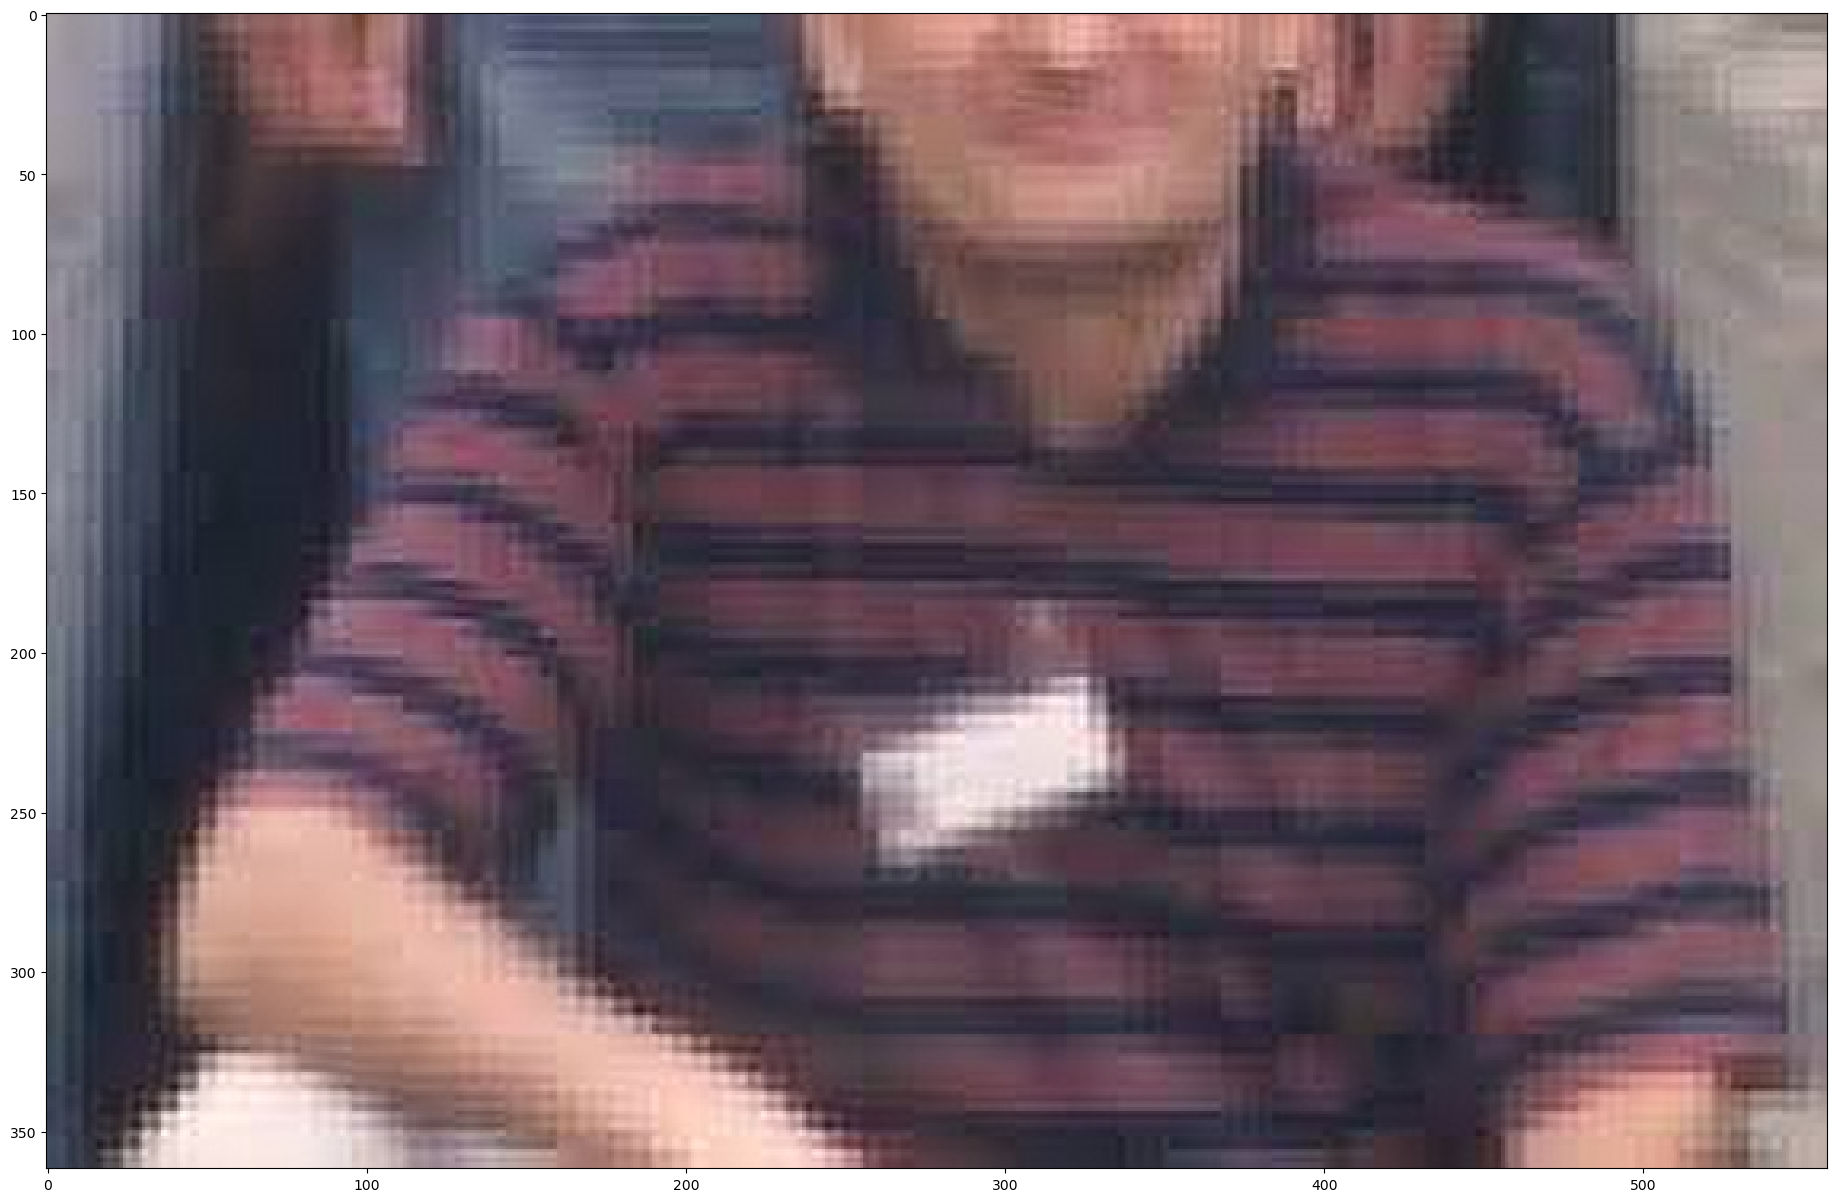

In [10]:
img_H_rgb = MFSR_1.img_H_rgb
# images = [img_L_rgb, img_H_rgb]
# vis_imgs(images)
plt.imshow(img_H_rgb)
plt.show()

img_route: ./Set5
./Set5\image_SRF_2/img_003_SRF_2_LR.png
6
size of the dic is : 334
patch count:  1000     loss:  0.01794417026062032
patch count:  2000     loss:  0.01883788961417576
patch count:  3000     loss:  0.017027289534026983
Fall back strategy
img_route: ./Set5
./Set5\image_SRF_2/img_003_SRF_2_HR.png
quick_eval: ./Set5
PSNR/SSIM for 003: 25.5451 dB / 0.8770
Scale  7  started 
Fall back strategy
img_route: ./Set5
./Set5\image_SRF_2/img_003_SRF_2_HR.png
quick_eval: ./Set5
PSNR/SSIM for 003: 27.2209 dB / 0.8963
Scale  8  started 
Fall back strategy
img_route: ./Set5
./Set5\image_SRF_2/img_003_SRF_2_HR.png
quick_eval: ./Set5
PSNR/SSIM for 003: 27.7121 dB / 0.9011
Scale  9  started 
Fall back strategy
img_route: ./Set5
./Set5\image_SRF_2/img_003_SRF_2_HR.png
quick_eval: ./Set5
PSNR/SSIM for 003: 28.0658 dB / 0.9052
Scale  10  started 
Fall back strategy
img_route: ./Set5
./Set5\image_SRF_2/img_003_SRF_2_HR.png
quick_eval: ./Set5
PSNR/SSIM for 003: 28.3160 dB / 0.9089
Scale  11  s

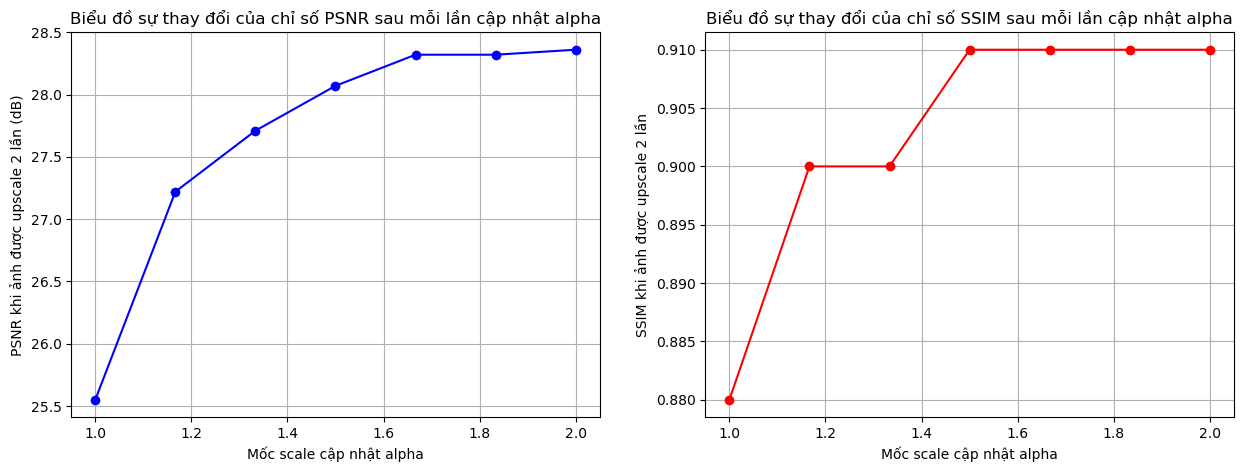

In [71]:
get_quality_and_plot_each_scale(dataset_route='./Set5', img_id='003', conscale=2)

img_route: ./BSD100
./BSD100\image_SRF_2/img_006_SRF_2_LR.png
6
size of the dic is : 334
patch count:  1000     loss:  0.017985355199849982
patch count:  2000     loss:  0.018410837607772495
patch count:  3000     loss:  0.018954005696855607
patch count:  4000     loss:  0.01755781522391755
patch count:  5000     loss:  0.01723813258068464
patch count:  6000     loss:  0.017179551250578413
patch count:  7000     loss:  0.017838746574354858
patch count:  8000     loss:  0.019022727074982274
patch count:  9000     loss:  0.019258749193605342
Fall back strategy
img_route: ./BSD100
./BSD100\image_SRF_2/img_006_SRF_2_HR.png
quick_eval: ./BSD100
PSNR/SSIM for 006: 33.8142 dB / 0.9258
Scale  7  started 
Fall back strategy
img_route: ./BSD100
./BSD100\image_SRF_2/img_006_SRF_2_HR.png
quick_eval: ./BSD100
PSNR/SSIM for 006: 35.0577 dB / 0.9413
Scale  8  started 
Fall back strategy
img_route: ./BSD100
./BSD100\image_SRF_2/img_006_SRF_2_HR.png
quick_eval: ./BSD100
PSNR/SSIM for 006: 35.3948 dB / 

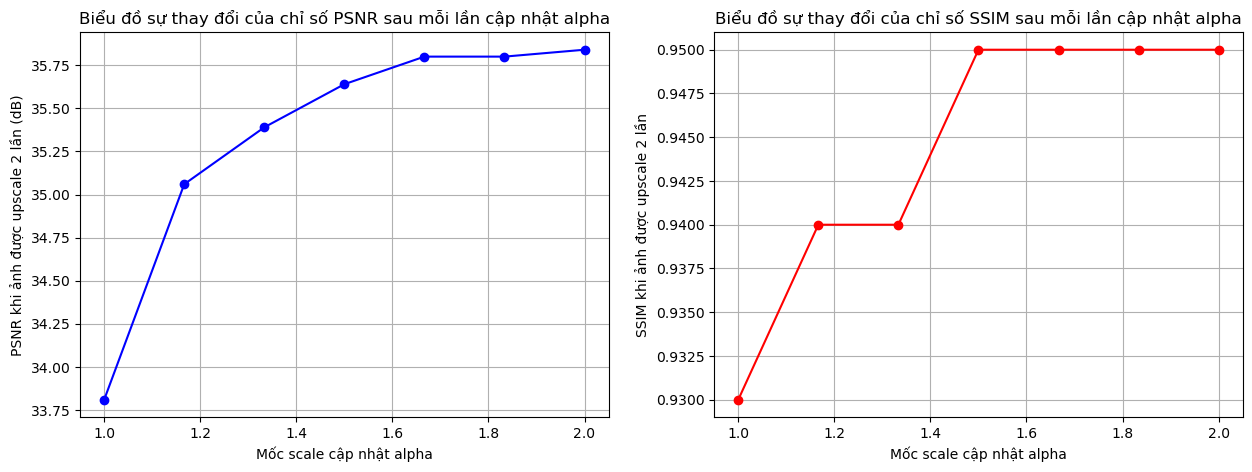

In [72]:
get_quality_and_plot_each_scale(dataset_route='./BSD100', img_id='006', conscale=2)